<a href="https://colab.research.google.com/github/ryanpereirax/Intrusion-detector-with-supervised-models/blob/main/fuzzy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
fuzzy_df = pd.read_csv('/content/Fuzzy_dataset.csv')


In [ ]:
# Amostras de 1% do Dataset Original
amostras_R = fuzzy_df[fuzzy_df['R'] == 'R'].sample(n=5_000, random_state=42)
amostras_T = fuzzy_df[fuzzy_df['R'] == 'T'].sample(n=4_000, random_state=42)
fuzzy_df_balanceado = pd.concat([amostras_R, amostras_T]).sample(frac=1, random_state=42).reset_index(drop=True)

fuzzy_df_balanceado.to_csv('fuzzy_df_proporcional_ajustado.csv', index=False)

In [ ]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.3 MB/s eta 0:00:00


In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd

# Carregar o arquivo para examinar os dados
file_path = "/content/dos_df_proporcional_ajustado.csv"
data = pd.read_csv(file_path)

# Verificar as primeiras linhas do dataset para compreender sua estrutura
data.head()


FileNotFoundError: [Errno 2] No such file or directory: '/content/dos_df_proporcional_ajustado.csv'

In [ ]:
# Renomear as colunas para melhor compreensão
data.columns = ['Timestamp', 'CAN_ID', 'DLC', 'DATA_0', 'DATA_1', 'DATA_2',
                'DATA_3', 'DATA_4', 'DATA_5', 'DATA_6', 'DATA_7', 'Flag']

# Verificar se existem valores ausentes
missing_data = data.isnull().sum()

# Analisar a proporção de flags 'T' e 'R'
flag_distribution = data['Flag'].value_counts(normalize=True)

# Examinar estatísticas descritivas para colunas numéricas
numeric_stats = data.describe()

missing_data, flag_distribution, numeric_stats


In [ ]:
# Converter o Timestamp para um formato de data legível para análise temporal
data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s')

# Criar uma nova coluna para armazenar apenas a hora das mensagens
data['Hour'] = data['Timestamp'].dt.hour

# Contar o número de mensagens por hora
messages_per_hour = data.groupby('Hour').size()

# Identificar quais CAN_IDs são mais frequentes
can_id_distribution = data['CAN_ID'].value_counts().head(10)

messages_per_hour, can_id_distribution


In [ ]:
# Verificar a distribuição dos CAN_IDs em relação às flags 'T' e 'R'
can_id_flag_distribution = data.groupby(['CAN_ID', 'Flag']).size().unstack(fill_value=0)

# Explorar padrões nos campos 'DATA_X' para mensagens com flag 'T'
data_injected = data[data['Flag'] == 'T']
data_normal = data[data['Flag'] == 'R']

# Calcular estatísticas descritivas para os campos 'DATA_X' para cada tipo de flag
data_injected_stats = data_injected[['DATA_0', 'DATA_1', 'DATA_2', 'DATA_3',
                                     'DATA_4', 'DATA_5', 'DATA_6', 'DATA_7']].describe()

data_normal_stats = data_normal[['DATA_0', 'DATA_1', 'DATA_2', 'DATA_3',
                                 'DATA_4', 'DATA_5', 'DATA_6', 'DATA_7']].describe()

can_id_flag_distribution, data_injected_stats, data_normal_stats


In [ ]:
# Verificar a distribuição temporal das mensagens com CAN_ID '0000' (flag 'T')
injected_id_0000 = data[(data['CAN_ID'] == '0000') & (data['Flag'] == 'T')]

# Contagem de mensagens injetadas por minuto
injected_id_0000['Minute'] = injected_id_0000['Timestamp'].dt.minute
injected_per_minute = injected_id_0000.groupby('Minute').size()

# Explorar CAN_IDs que aparecem menos frequentemente para identificar possíveis outliers
rare_can_ids = data['CAN_ID'].value_counts().tail(10)

# Verificar se existem correlações entre os campos 'DATA_X' para as mensagens normais
data_normal_numeric = data_normal[['DATA_0', 'DATA_1', 'DATA_2', 'DATA_3',
                                   'DATA_4', 'DATA_5', 'DATA_6', 'DATA_7']].apply(lambda x: x.apply(int, base=16))
correlation_matrix = data_normal_numeric.corr()

injected_per_minute, rare_can_ids, correlation_matrix


In [ ]:
# Converter os campos 'DATA_X' para valores numéricos para análise de correlação
data_numeric = data[['DATA_0', 'DATA_1', 'DATA_2', 'DATA_3',
                     'DATA_4', 'DATA_5', 'DATA_6', 'DATA_7']].apply(lambda x: x.apply(int, base=16))

# Adicionar a flag como numérica (T = 1, R = 0) para facilitar a análise
data_numeric['Flag'] = data['Flag'].apply(lambda x: 1 if x == 'T' else 0)

# Calcular a correlação entre os campos de dados e a flag
correlation_with_flag = data_numeric.corr()['Flag'].drop('Flag')

correlation_with_flag


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, roc_auc_score, f1_score
)

# Supondo que 'data_numeric' esteja carregado corretamente
X = data_numeric.drop('Flag', axis=1)
y = data_numeric['Flag']

# Dividindo os dados em treino (60%), validação (20%) e teste (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Aplicando o MinMaxScaler nos conjuntos de treino, validação e teste
scaler_minmax = MinMaxScaler()

X_train_scaled = scaler_minmax.fit_transform(X_train)
X_val_scaled = scaler_minmax.transform(X_val)
X_test_scaled = scaler_minmax.transform(X_test)

# Criando o modelo de Regressão Logística
model_minmax = LogisticRegression(
    penalty='l2',
    solver='lbfgs',
    max_iter=500,
    random_state=42
)

# Treinando o modelo com os dados de treino
model_minmax.fit(X_train_scaled, y_train)

# Função para calcular e exibir métricas
def print_metrics(y_true, y_pred, y_prob, dataset_name):
    print(f"\nMétricas para o conjunto de {dataset_name}:")
    print(f"Acurácia: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precisão: {precision_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_true, y_prob):.4f}")
    print("\nMatriz de Confusão:")
    print(confusion_matrix(y_true, y_pred))


# Avaliando no conjunto de treino
y_train_pred = model_minmax.predict(X_train_scaled)
y_train_prob = model_minmax.predict_proba(X_train_scaled)[:, 1]
print_metrics(y_train, y_train_pred, y_train_prob, "Treino")


# Avaliando no conjunto de teste
y_test_pred = model_minmax.predict(X_test_scaled)
y_test_prob = model_minmax.predict_proba(X_test_scaled)[:, 1]
print_metrics(y_test, y_test_pred, y_test_prob, "Teste")

# Avaliando no conjunto de validação
y_val_pred = model_minmax.predict(X_val_scaled)
y_val_prob = model_minmax.predict_proba(X_val_scaled)[:, 1]
print_metrics(y_val, y_val_pred, y_val_prob, "Validação")


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, roc_auc_score, f1_score
)

# Supondo que 'data_numeric' esteja carregado corretamente
X = data_numeric.drop('Flag', axis=1)
y = data_numeric['Flag']

# Dividindo os dados em treino (60%), validação (20%) e teste (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Aplicando o MinMaxScaler nos conjuntos de treino, validação e teste
scaler_minmax = MinMaxScaler()

X_train_scaled = scaler_minmax.fit_transform(X_train)
X_val_scaled = scaler_minmax.transform(X_val)
X_test_scaled = scaler_minmax.transform(X_test)

# Criando e treinando o modelo Random Forest com regularização
model_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

model_rf.fit(X_train_scaled, y_train)

# Função para calcular e exibir métricas
def print_metrics_rf(y_true, y_pred, y_prob, dataset_name):
    print(f"\nMétricas para o conjunto de {dataset_name}:")
    print(f"Acurácia: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precisão: {precision_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_true, y_prob):.4f}")
    print("\nMatriz de Confusão:")
    print(confusion_matrix(y_true, y_pred))


# Avaliar no conjunto de treino
y_train_pred_rf = model_rf.predict(X_train_scaled)
y_train_prob_rf = model_rf.predict_proba(X_train_scaled)[:, 1]
print_metrics_rf(y_train, y_train_pred_rf, y_train_prob_rf, "Treino")


# Avaliar no conjunto de teste
y_test_pred_rf = model_rf.predict(X_test_scaled)
y_test_prob_rf = model_rf.predict_proba(X_test_scaled)[:, 1]
print_metrics_rf(y_test, y_test_pred_rf, y_test_prob_rf, "Teste")

# Avaliar no conjunto de validação
y_val_pred_rf = model_rf.predict(X_val_scaled)
y_val_prob_rf = model_rf.predict_proba(X_val_scaled)[:, 1]
print_metrics_rf(y_val, y_val_pred_rf, y_val_prob_rf, "Validação")

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, roc_auc_score, f1_score
)

# Supondo que 'data_numeric' esteja carregado corretamente
X = data_numeric.drop('Flag', axis=1)
y = data_numeric['Flag']

# Dividindo os dados em treino (60%), validação (20%) e teste (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Aplicando o MinMaxScaler nos conjuntos de treino, validação e teste
scaler_minmax = MinMaxScaler()

X_train_scaled = scaler_minmax.fit_transform(X_train)
X_val_scaled = scaler_minmax.transform(X_val)
X_test_scaled = scaler_minmax.transform(X_test)

# Criando e treinando o modelo de Árvore de Decisão com regularização
model_tree = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

model_tree.fit(X_train_scaled, y_train)

# Função para calcular e exibir métricas
def print_metrics_tree(y_true, y_pred, y_prob, dataset_name):
    print(f"\nMétricas para o conjunto de {dataset_name}:")
    print(f"Acurácia: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precisão: {precision_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_true, y_prob):.4f}")
    print("\nMatriz de Confusão:")
    print(confusion_matrix(y_true, y_pred))


# Avaliar no conjunto de treino
y_train_pred_tree = model_tree.predict(X_train_scaled)
y_train_prob_tree = model_tree.predict_proba(X_train_scaled)[:, 1]
print_metrics_tree(y_train, y_train_pred_tree, y_train_prob_tree, "Treino")


# Avaliar no conjunto de teste
y_test_pred_tree = model_tree.predict(X_test_scaled)
y_test_prob_tree = model_tree.predict_proba(X_test_scaled)[:, 1]
print_metrics_tree(y_test, y_test_pred_tree, y_test_prob_tree, "Teste")

# Avaliar no conjunto de validação
y_val_pred_tree = model_tree.predict(X_val_scaled)
y_val_prob_tree = model_tree.predict_proba(X_val_scaled)[:, 1]
print_metrics_tree(y_val, y_val_pred_tree, y_val_prob_tree, "Validação")

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, roc_auc_score, f1_score
)

# Supondo que 'data_numeric' esteja carregado corretamente
X = data_numeric.drop('Flag', axis=1)
y = data_numeric['Flag']

# Dividindo os dados em treino (60%), validação (20%) e teste (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Aplicando o MinMaxScaler nos conjuntos de treino, validação e teste
scaler_minmax = MinMaxScaler()

X_train_scaled = scaler_minmax.fit_transform(X_train)
X_val_scaled = scaler_minmax.transform(X_val)
X_test_scaled = scaler_minmax.transform(X_test)

# Criando e treinando o modelo de Gradient Boosting
model_gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

model_gb.fit(X_train_scaled, y_train)

# Função para calcular e exibir métricas
def print_metrics_gb(y_true, y_pred, y_prob, dataset_name):
    print(f"\nMétricas para o conjunto de {dataset_name}:")
    print(f"Acurácia: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precisão: {precision_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_true, y_prob):.4f}")
    print("\nMatriz de Confusão:")
    print(confusion_matrix(y_true, y_pred))

# Avaliar no conjunto de treino
y_train_pred_gb = model_gb.predict(X_train_scaled)
y_train_prob_gb = model_gb.predict_proba(X_train_scaled)[:, 1]
print_metrics_gb(y_train, y_train_pred_gb, y_train_prob_gb, "Treino")


# Avaliar no conjunto de teste
y_test_pred_gb = model_gb.predict(X_test_scaled)
y_test_prob_gb = model_gb.predict_proba(X_test_scaled)[:, 1]
print_metrics_gb(y_test, y_test_pred_gb, y_test_prob_gb, "Teste")

# Avaliar no conjunto de validação
y_val_pred_gb = model_gb.predict(X_val_scaled)
y_val_prob_gb = model_gb.predict_proba(X_val_scaled)[:, 1]
print_metrics_gb(y_val, y_val_pred_gb, y_val_prob_gb, "Validação")

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, roc_auc_score, f1_score
)

# Supondo que 'data_numeric' esteja carregado corretamente
X = data_numeric.drop('Flag', axis=1)
y = data_numeric['Flag']

# Dividindo os dados em treino (60%), validação (20%) e teste (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Aplicando o MinMaxScaler nos conjuntos de treino, validação e teste
scaler_minmax = MinMaxScaler()

X_train_scaled = scaler_minmax.fit_transform(X_train)
X_val_scaled = scaler_minmax.transform(X_val)
X_test_scaled = scaler_minmax.transform(X_test)

# Criando e treinando o modelo K-Nearest Neighbors
model_knn = KNeighborsClassifier(
    n_neighbors=5,
    weights='uniform',
    metric='minkowski',
    n_jobs=-1
)

model_knn.fit(X_train_scaled, y_train)

# Função para calcular e exibir métricas
def print_metrics_knn(y_true, y_pred, y_prob, dataset_name):
    print(f"\nMétricas para o conjunto de {dataset_name}:")
    print(f"Acurácia: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precisão: {precision_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_true, y_prob):.4f}")
    print("\nMatriz de Confusão:")
    print(confusion_matrix(y_true, y_pred))


# Avaliar no conjunto de treino
y_train_pred_knn = model_knn.predict(X_train_scaled)
y_train_prob_knn = model_knn.predict_proba(X_train_scaled)[:, 1]
print_metrics_knn(y_train, y_train_pred_knn, y_train_prob_knn, "Treino")


# Avaliar no conjunto de teste
y_test_pred_knn = model_knn.predict(X_test_scaled)
y_test_prob_knn = model_knn.predict_proba(X_test_scaled)[:, 1]
print_metrics_knn(y_test, y_test_pred_knn, y_test_prob_knn, "Teste")

# Avaliar no conjunto de validação
y_val_pred_knn = model_knn.predict(X_val_scaled)
y_val_prob_knn = model_knn.predict_proba(X_val_scaled)[:, 1]
print_metrics_knn(y_val, y_val_pred_knn, y_val_prob_knn, "Validação")


In [ ]:

from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, roc_auc_score, f1_score
)

# Supondo que 'data_numeric' esteja carregado corretamente
X = data_numeric.drop('Flag', axis=1)
y = data_numeric['Flag']

# Dividindo os dados em treino (60%), validação (20%) e teste (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Aplicando o MinMaxScaler nos conjuntos de treino, validação e teste
scaler_minmax = MinMaxScaler()

X_train_scaled = scaler_minmax.fit_transform(X_train)
X_val_scaled = scaler_minmax.transform(X_val)
X_test_scaled = scaler_minmax.transform(X_test)

# Criando e treinando o modelo SVM
model_svm = SVC(
    kernel='rbf',
    C=1.0,
    probability=True,
    random_state=42
)

model_svm.fit(X_train_scaled, y_train)

# Função para calcular e exibir métricas
def print_metrics_svm(y_true, y_pred, y_prob, dataset_name):
    print(f"\nMétricas para o conjunto de {dataset_name}:")
    print(f"Acurácia: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precisão: {precision_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_true, y_prob):.4f}")
    print("\nMatriz de Confusão:")
    print(confusion_matrix(y_true, y_pred))

# Avaliar no conjunto de treino
y_train_pred_svm = model_svm.predict(X_train_scaled)
y_train_prob_svm = model_svm.predict_proba(X_train_scaled)[:, 1]
print_metrics_svm(y_train, y_train_pred_svm, y_train_prob_svm, "Treino")


# Avaliar no conjunto de teste
y_test_pred_svm = model_svm.predict(X_test_scaled)
y_test_prob_svm = model_svm.predict_proba(X_test_scaled)[:, 1]
print_metrics_svm(y_test, y_test_pred_svm, y_test_prob_svm, "Teste")

# Avaliar no conjunto de validação
y_val_pred_svm = model_svm.predict(X_val_scaled)
y_val_prob_svm = model_svm.predict_proba(X_val_scaled)[:, 1]
print_metrics_svm(y_val, y_val_pred_svm, y_val_prob_svm, "Validação")



In [ ]:
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, roc_auc_score, f1_score
)

X = data_numeric.drop('Flag', axis=1)
y = data_numeric['Flag']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler_minmax = MinMaxScaler()

X_train_scaled = scaler_minmax.fit_transform(X_train)
X_val_scaled = scaler_minmax.transform(X_val)
X_test_scaled = scaler_minmax.transform(X_test)

# Criando e treinando o modelo XGBoost
model_xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=10,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model_xgb.fit(X_train_scaled, y_train)

# Função para calcular e exibir métricas
def print_metrics_xgb(y_true, y_pred, y_prob, dataset_name):
    print(f"\nMétricas para o conjunto de {dataset_name}:")
    print(f"Acurácia: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precisão: {precision_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_true, y_prob):.4f}")
    print("\nMatriz de Confusão:")
    print(confusion_matrix(y_true, y_pred))


# Avaliar no conjunto de treino
y_train_pred_xgb = model_xgb.predict(X_train_scaled)
y_train_prob_xgb = model_xgb.predict_proba(X_train_scaled)[:, 1]
print_metrics_xgb(y_train, y_train_pred_xgb, y_train_prob_xgb, "Treino")


# Avaliar no conjunto de teste
y_test_pred_xgb = model_xgb.predict(X_test_scaled)
y_test_prob_xgb = model_xgb.predict_proba(X_test_scaled)[:, 1]
print_metrics_xgb(y_test, y_test_pred_xgb, y_test_prob_xgb, "Teste")

# Avaliar no conjunto de validação
y_val_pred_xgb = model_xgb.predict(X_val_scaled)
y_val_prob_xgb = model_xgb.predict_proba(X_val_scaled)[:, 1]
print_metrics_xgb(y_val, y_val_pred_xgb, y_val_prob_xgb, "Validação")


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, roc_auc_score, f1_score
)

# Supondo que 'data_numeric' esteja carregado corretamente
X = data_numeric.drop('Flag', axis=1)
y = data_numeric['Flag']

# Dividindo os dados em treino (60%), validação (20%) e teste (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Aplicando o MinMaxScaler nos conjuntos de treino, validação e teste
scaler_minmax = MinMaxScaler()

X_train_scaled = scaler_minmax.fit_transform(X_train)
X_val_scaled = scaler_minmax.transform(X_val)
X_test_scaled = scaler_minmax.transform(X_test)

# Criando e treinando o modelo CatBoost
model_cb = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=10,
    random_seed=42,
    verbose=0
)

model_cb.fit(X_train_scaled, y_train)

# Função para calcular e exibir métricas
def print_metrics_cb(y_true, y_pred, y_prob, dataset_name):
    print(f"\nMétricas para o conjunto de {dataset_name}:")
    print(f"Acurácia: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precisão: {precision_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_true, y_prob):.4f}")
    print("\nMatriz de Confusão:")
    print(confusion_matrix(y_true, y_pred))


# Avaliar no conjunto de treino
y_train_pred_cb = model_cb.predict(X_train_scaled)
y_train_prob_cb = model_cb.predict_proba(X_train_scaled)[:, 1]
print_metrics_cb(y_train, y_train_pred_cb, y_train_prob_cb, "Treino")


# Avaliar no conjunto de teste
y_test_pred_cb = model_cb.predict(X_test_scaled)
y_test_prob_cb = model_cb.predict_proba(X_test_scaled)[:, 1]
print_metrics_cb(y_test, y_test_pred_cb, y_test_prob_cb, "Teste")

# Avaliar no conjunto de validação
y_val_pred_cb = model_cb.predict(X_val_scaled)
y_val_prob_cb = model_cb.predict_proba(X_val_scaled)[:, 1]
print_metrics_cb(y_val, y_val_pred_cb, y_val_prob_cb, "Validação")


In [ ]:
pip install statsmodels --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 12.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Dados das métricas para cada modelo
data = {
    'Modelo': [
        'Logistic Regression', 'Logistic Regression', 'Logistic Regression',
        'Random Forest', 'Random Forest', 'Random Forest',
        'Decision Tree', 'Decision Tree', 'Decision Tree',
        'Gradient Boosting', 'Gradient Boosting', 'Gradient Boosting',
        'KNN', 'KNN', 'KNN',
        'SVM', 'SVM', 'SVM',
        'XGBoost', 'XGBoost', 'XGBoost',
        'CatBoost', 'CatBoost', 'CatBoost',
    ],
    'Métrica': [
        'Acurácia', 'Precisão', 'F1-Score',
        'Acurácia', 'Precisão', 'F1-Score',
        'Acurácia', 'Precisão', 'F1-Score',
        'Acurácia', 'Precisão', 'F1-Score',
        'Acurácia', 'Precisão', 'F1-Score',
        'Acurácia', 'Precisão', 'F1-Score',
        'Acurácia', 'Precisão', 'F1-Score',
        'Acurácia', 'Precisão', 'F1-Score'  # Adicionei para ajustar o comprimento
    ],
    'Valor': [
        0.9581, 0.9710, 0.9515,  # Logistic
        1.000, 1.000, 1.000,  # Random Forest
        0.9966, 0.9995, 0.9961,  # Decision
        0.9983, 0.9983, 0.9980,  # Gradient Boosting
        0.9939, 0.9995, 0.9931, # KNN
        0.9973, 1.000, 0.9970,  # SVM
        0.9998, 1.000, 0.9998,  # XGBoost
        0.9992, 1.000, 0.9991   # CatBoost
    ]
}

# Criando o DataFrame
df = pd.DataFrame(data)

# Verificando o DataFrame
print(df)


                 Modelo   Métrica   Valor
0   Logistic Regression  Acurácia  0.9581
1   Logistic Regression  Precisão  0.9710
2   Logistic Regression  F1-Score  0.9515
3         Random Forest  Acurácia  1.0000
4         Random Forest  Precisão  1.0000
5         Random Forest  F1-Score  1.0000
6         Decision Tree  Acurácia  0.9966
7         Decision Tree  Precisão  0.9995
8         Decision Tree  F1-Score  0.9961
9     Gradient Boosting  Acurácia  0.9983
10    Gradient Boosting  Precisão  0.9983
11    Gradient Boosting  F1-Score  0.9980
12                  KNN  Acurácia  0.9939
13                  KNN  Precisão  0.9995
14                  KNN  F1-Score  0.9931
15                  SVM  Acurácia  0.9973
16                  SVM  Precisão  1.0000
17                  SVM  F1-Score  0.9970
18              XGBoost  Acurácia  0.9998
19              XGBoost  Precisão  1.0000
20              XGBoost  F1-Score  0.9998
21             CatBoost  Acurácia  0.9992
22             CatBoost  Precisão 

<ipython-input-27-605b3ecb10ae>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rankings = df.groupby('Métrica').apply(lambda x: x.sort_values(by='Valor', ascending=False).reset_index(drop=True))


             Métrica               Modelo   Valor
Métrica                                          
Acurácia 0  Acurácia        Random Forest  1.0000
         1  Acurácia              XGBoost  0.9998
         2  Acurácia             CatBoost  0.9992
         3  Acurácia    Gradient Boosting  0.9983
         4  Acurácia                  SVM  0.9973
         5  Acurácia        Decision Tree  0.9966
         6  Acurácia                  KNN  0.9939
         7  Acurácia  Logistic Regression  0.9581
F1-Score 0  F1-Score        Random Forest  1.0000
         1  F1-Score              XGBoost  0.9998
         2  F1-Score             CatBoost  0.9991
         3  F1-Score    Gradient Boosting  0.9980
         4  F1-Score                  SVM  0.9970
         5  F1-Score        Decision Tree  0.9961
         6  F1-Score                  KNN  0.9931
         7  F1-Score  Logistic Regression  0.9515
Precisão 0  Precisão        Random Forest  1.0000
         1  Precisão             CatBoost  1.0000


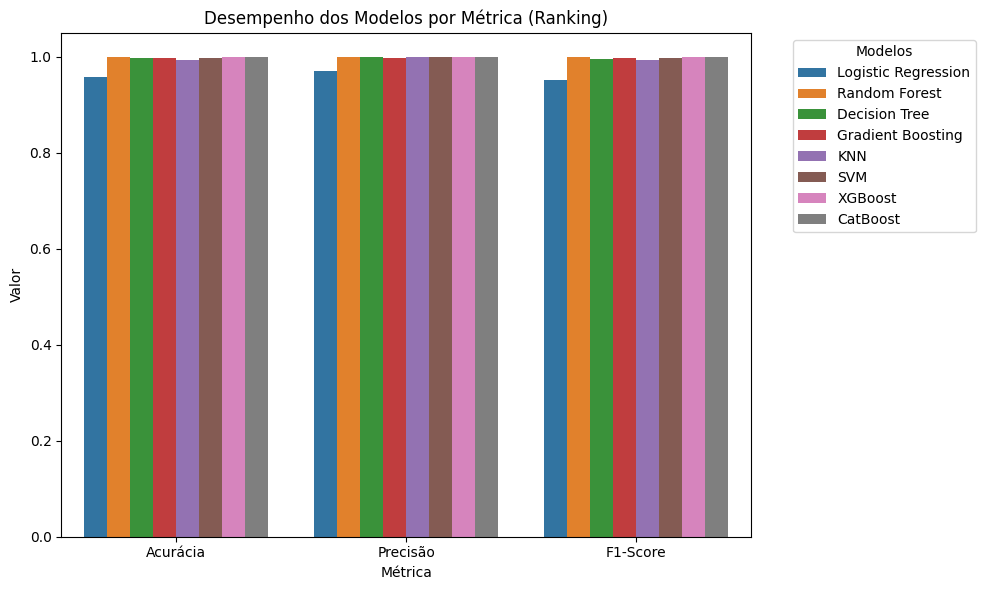

In [ ]:
# Criar ranking dos modelos por métrica
rankings = df.groupby('Métrica').apply(lambda x: x.sort_values(by='Valor', ascending=False).reset_index(drop=True))
rankings = rankings[['Métrica', 'Modelo', 'Valor']]

# Exibir rankings
print(rankings)

# Gráfico de barras do ranking
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Métrica', y='Valor', hue='Modelo')
plt.title("Desempenho dos Modelos por Métrica (Ranking)")
plt.ylabel("Valor")
plt.xlabel("Métrica")
plt.legend(title="Modelos", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


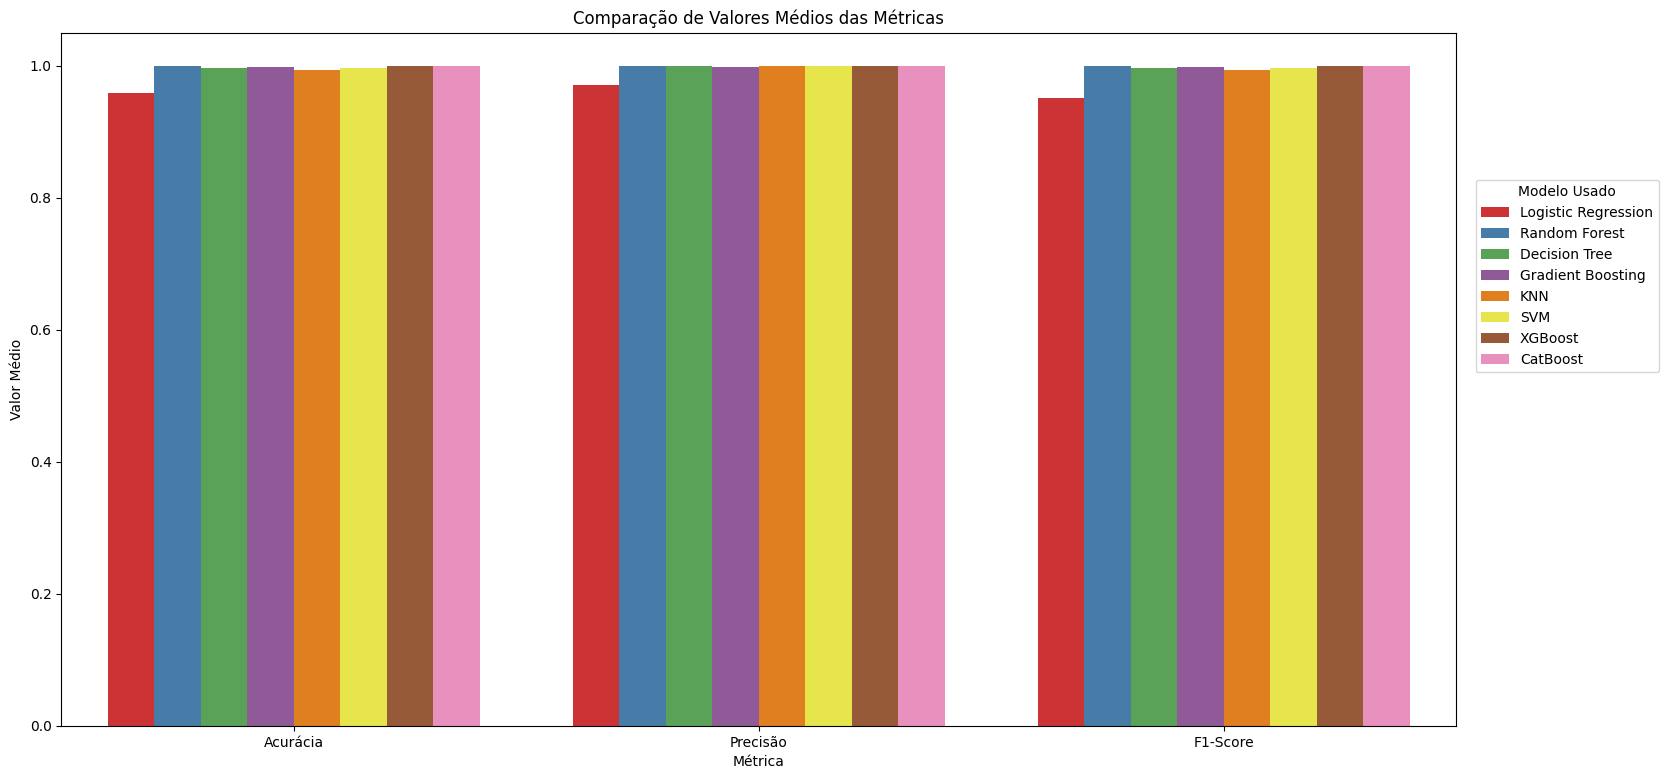

In [ ]:
plt.figure(figsize=(18, 9))
sns.barplot(data=df, x="Métrica", y="Valor", hue="Modelo", errorbar=None, palette="Set1")
plt.title("Comparação de Valores Médios das Métricas")
plt.ylabel("Valor Médio")
plt.xlabel("Métrica")
plt.legend(loc="lower right", bbox_to_anchor=(1.15, 0.5), title="Modelo Usado")
plt.show()


<ipython-input-31-2df2c7e70565>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_auc_roc, x='Modelo', y='AUC-ROC Média', palette='viridis')


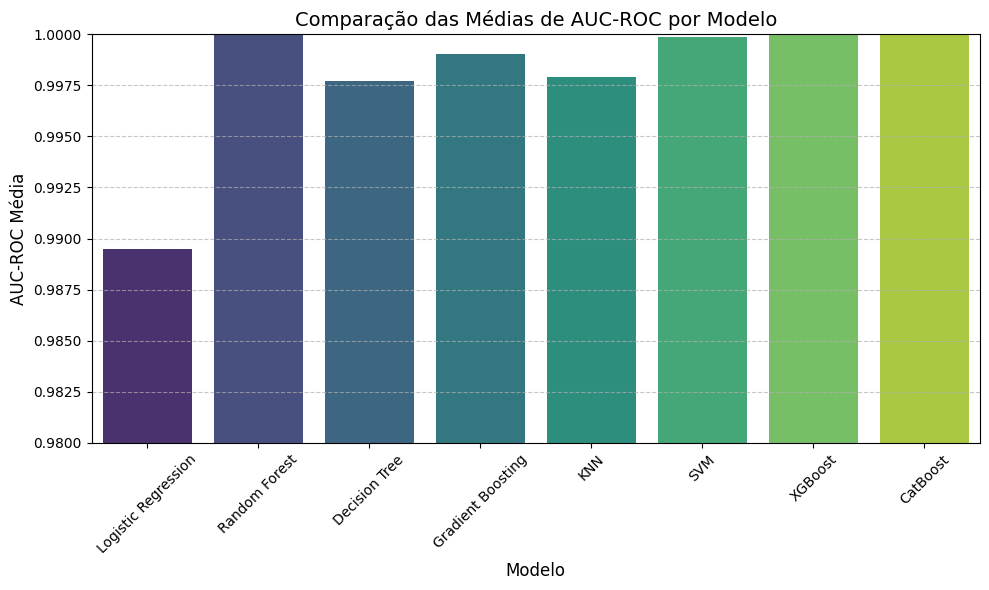

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Valores médios de AUC-ROC para cada modelo
auc_roc_values = {
    'Modelo': [
        'Logistic Regression', 'Random Forest', 'Decision Tree',
        'Gradient Boosting', 'KNN','SVM', 'XGBoost', 'CatBoost'
    ],
    'AUC-ROC Média': [0.9894666666666667, 1, 0.9977, 0.9990333333333333, 0.9979333333333333, 0.9998666666666667, 1, 1]
}

# Criar um DataFrame para facilitar o uso
df_auc_roc = pd.DataFrame(auc_roc_values)

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(data=df_auc_roc, x='Modelo', y='AUC-ROC Média', palette='viridis')

# Personalizar o gráfico
plt.title('Comparação das Médias de AUC-ROC por Modelo', fontsize=14)
plt.ylabel('AUC-ROC Média', fontsize=12)
plt.xlabel('Modelo', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.ylim(0.98, 1.0)  # Ajustar o eixo Y para focar nas diferenças
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar o gráfico
plt.tight_layout()
plt.show()
